# OpenCL图像处理-彩色图像灰度化

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import skimage as ski
import skimage.io as skio
import cv2
import pyopencl as cl

In [6]:
src = skio.imread('../../datas/f2.jpg')
rgba = cv2.cvtColor(src,cv2.COLOR_RGB2RGBA)
print(rgba.shape)

(480, 640, 4)


In [7]:
def load_kernel_from_file(ctx,fname):
    sources = None
    kernel = None
    with open(fname,encoding='utf-8') as f:
        sources = str(f.read())
        kernel = cl.Program(ctx,sources).build()
    return kernel

In [26]:
def init_cl():
    # 创建Context
    # 如果有多个设备，则会提示选择
    ctx = cl.create_some_context()
    # 创建CommandQueue
    queue = cl.CommandQueue(ctx)
    return ctx,queue

def copy_image_to_device_readonly(ctx,src,imgformat):
    #imageFormat = cl.ImageFormat(cl.channel_order.RGBA,cl.channel_type.UNSIGNED_INT8)
    mf = cl.mem_flags
    img = cl.Image(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR,imgformat,(src.shape[0],src.shape[1]),None,src.tobytes())
    return img
def create_device_write_only_image(ctx,imgformat,shape):
    mf = cl.mem_flags
    out = cl.Image(context=ctx,flags=mf.WRITE_ONLY,format=imgformat,shape=shape)
    return out
def copy_image_to_host(queue,output,size,dtype):
    buffer = np.zeros(size[0] * size[1] * 4,dtype=dtype)
    origin = ( 0, 0, 0 )
    region = (size[0] ,size[1], 1 ) 
    cl.enqueue_read_image(queue, output,
                        origin, region, buffer).wait()
    return buffer.reshape(size)


In [9]:
def cal_work_size(groupSize, globalSize):  
    r = globalSize % groupSize;  
    if r == 0:  
        return globalSize
    else:  
        return globalSize + groupSize - r

In [10]:
ctx,queue = init_cl()

In [11]:
kernel = load_kernel_from_file(ctx,'../../datas/cl/rgb2gray.cl')

In [12]:
imageFormat = cl.ImageFormat(cl.channel_order.RGBA,cl.channel_type.UNSIGNED_INT8)
img_in_dev = copy_image_to_device_readonly(ctx,rgba,imageFormat)

In [13]:
img_out_dev = create_device_write_only_image(ctx,imageFormat,(rgba.shape[0],rgba.shape[1]))

In [15]:
local_work_size = ( 8, 8 )  
global_work_size = ( cal_work_size(local_work_size[0], src.shape[0]),  
                    cal_work_size(local_work_size[1], src.shape[1]))
print(local_work_size,global_work_size)
kernel.gray_avg_filter(queue,global_work_size,local_work_size,img_in_dev,img_out_dev)

(8, 8) (480, 640)


In [27]:
output = copy_image_to_host(queue,img_out_dev,rgba.shape,np.uint8)

C:\Users\jenson\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: 'enqueue_read_image' has been deprecated in version 2011.1. Please use enqueue_copy() instead.


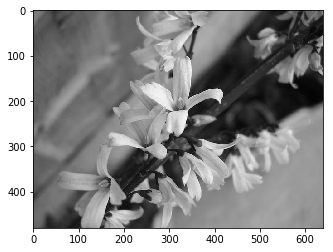

In [28]:
plt.imshow(output,'gray')